In [46]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split,GridSearchCV, cross_validate
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
import imblearn

import pickle

from xgboost import XGBClassifier

In [2]:
sns.set_style('whitegrid')

In [3]:
# census = pd.read_parquet('data/refined/census_data.parquet')

In [3]:
df_mailout = pd.read_parquet('data/refined/full_mailout_train.parquet')

# Response variable

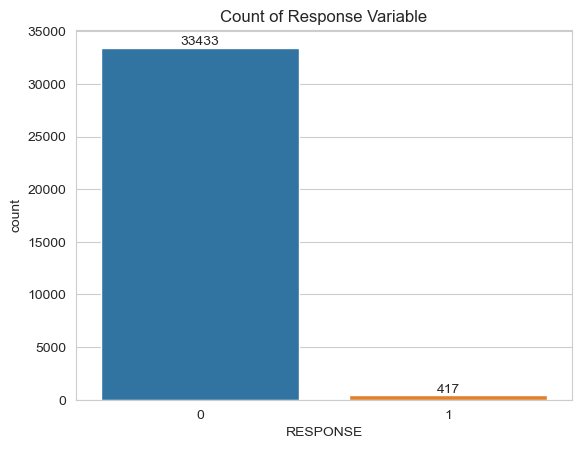

In [4]:
g = sns.countplot(data = df_mailout,
                    x = 'RESPONSE')

g.bar_label(g.containers[-1])

plt.title('Count of Response Variable')

plt.show()

In [5]:
df_mailout['RESPONSE'].value_counts(normalize = True)

0    0.987681
1    0.012319
Name: RESPONSE, dtype: float64

The data is HEAVILY imbalanced. A little more than 1% actually responded to the mailing.  
This is not inherently bad. Some methods can be used like up- or downsampling but not necessairly.  
Either way, given this hard imbalace, accuracy should not be used since in this context it is a biased metric

# Segmenting variable types

In [6]:
census_var_types = pd.read_excel('data/raw/DIAS Attributes - Values 2017.xlsx',
                                    sheet_name='Tabelle1_fixed',
                                    usecols = 'B:C',
                                    header = 1)\
                                    .dropna()

In [7]:
census_var_types.head()

,Attribute,Type
0,AGER_TYP,nominal
5,ALTERSKATEGORIE_GROB,interval
11,ALTER_HH,interval
33,ANREDE_KZ,binary
36,ANZ_HAUSHALTE_AKTIV,numeric


In [8]:
census_var_types.loc[census_var_types['Attribute'] == 'ANZ_HH_TITEL','Type'] = 'binary'

In [9]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, df_mailout.columns)

In [10]:
for col in binary_vars:
    
    try:
        print(col, df_mailout[col].unique())

    except:

        print(f'Column not found: {col}')

        continue

ANREDE_KZ [2 1]
ANZ_HH_TITEL [0. 1.]
GREEN_AVANTGARDE [0 1]
KBA05_SEG6 [0. 1.]
OST_WEST_KZ [1. 0.]
VERS_TYP [2. 1.]


In [11]:
df_mailout['ANREDE_KZ'] = df_mailout['ANREDE_KZ'] - 1

df_mailout['VERS_TYP'] = df_mailout['VERS_TYP'] - 1

In [12]:
nominal_vars = census_var_types[census_var_types['Type'] == 'nominal']['Attribute'].values

nominal_vars = np.intersect1d(nominal_vars, df_mailout.columns)

In [13]:
interval_vars = census_var_types[census_var_types['Type'] == 'interval']['Attribute'].values

interval_vars = np.intersect1d(interval_vars, df_mailout.columns)

In [14]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, df_mailout.columns)

In [15]:
num_cols = df_mailout.columns.drop(list(nominal_vars) + list(binary_vars) + list(interval_vars) + ['LNR','RESPONSE'])

In [16]:
assert (len(nominal_vars) + len(binary_vars) + len(interval_vars) + len(num_cols) + 1) == len(df_mailout.columns.drop('RESPONSE'))

# Splitting Data

In [17]:
X = df_mailout.drop(columns = ['LNR','RESPONSE'])

y = df_mailout['RESPONSE']

In [18]:
feature_list = df_mailout.columns.drop(['LNR','RESPONSE'])

nominal_vars_pos = [feature_list.get_loc(col) for col in X.columns if col in nominal_vars]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify = y,random_state=42)

In [20]:
y_train.value_counts(normalize = True)

0    0.987666
1    0.012334
Name: RESPONSE, dtype: float64

In [21]:
y_test.value_counts(normalize = True)

0    0.98774
1    0.01226
Name: RESPONSE, dtype: float64

# Testing base models
Vanilla models to pick best option for tuning

In [42]:
# Models to be tested
dt = DecisionTreeClassifier(class_weight='balanced')

rf = RandomForestClassifier(class_weight='balanced',random_state=42, n_jobs=-1)

# Instantiating an XGB to match the closest possible characteristics with balanced class_weights
xgb = XGBClassifier(scale_pos_weight = 80,n_thread = 4, random_state = 42)

lr = LogisticRegression(n_jobs = -1,class_weight='balanced',random_state=42)

In [23]:
ohe_transformer = make_column_transformer((OneHotEncoder(),nominal_vars_pos),remainder = 'passthrough') # Using positions for more flexibility (np.array)

In [24]:
# Models to be tested
pipe_dt = Pipeline([('ohe',ohe_transformer),('Decision Tree',dt)])

pipe_rf = Pipeline([('ohe',ohe_transformer),('RF',rf)])

# Instantiating an XGB to match the closest possible characteristics with balanced class_weights
pipe_xgb = Pipeline([('ohe',ohe_transformer),('XGB',xgb)])

pipe_lr = Pipeline([('ohe',ohe_transformer),('LR',lr)])

In [25]:
models_dict = {'Decision Tree':pipe_dt, 'Random Forest':pipe_rf,'XGBoost':pipe_xgb, 'LogisticRegression':pipe_lr}

In [26]:
skfold = StratifiedKFold(n_splits = 5, random_state = 123, shuffle = True)

In [27]:
def evaluate_models(X,y,dict_models,cv):

    for i, (name, model) in enumerate(dict_models.items()):

        scores = cross_validate(model, X, y, cv=cv, scoring=['roc_auc','f1'], n_jobs= -1, verbose = 1, return_train_score=True)

        scores['model'] = name

        if i == 0:

            records = [scores]

        else:

            records.append(scores)

    for i, r in enumerate(records):

        temp = pd.DataFrame.from_dict(r)

        if i == 0:

            results_df = temp
        
        else:

            results_df = pd.concat([results_df, temp])
        
    results_df.reset_index(inplace = True)

    results_df.rename(columns = {'index':'Fold'}, inplace = True)

    return results_df

In [28]:
results_df = evaluate_models(X_train, y_train, dict_models = models_dict, cv = skfold)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.3s remaining:   20.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   53.3s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.9s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.2s finished


In [29]:
results_plot = results_df.melt(id_vars = ['model','Fold'], value_vars = ['test_roc_auc','train_roc_auc','test_f1','train_f1'])

In [30]:
results_df.groupby('model')[['test_roc_auc','train_roc_auc']].mean()

,test_roc_auc,train_roc_auc
model,,
Decision Tree,0.509509,1.000000
LogisticRegression,0.569972,0.730182
Random Forest,0.563266,1.000000
XGBoost,0.600843,1.000000


Due to the difference between train and test set performance, the models seem to overfit on training data

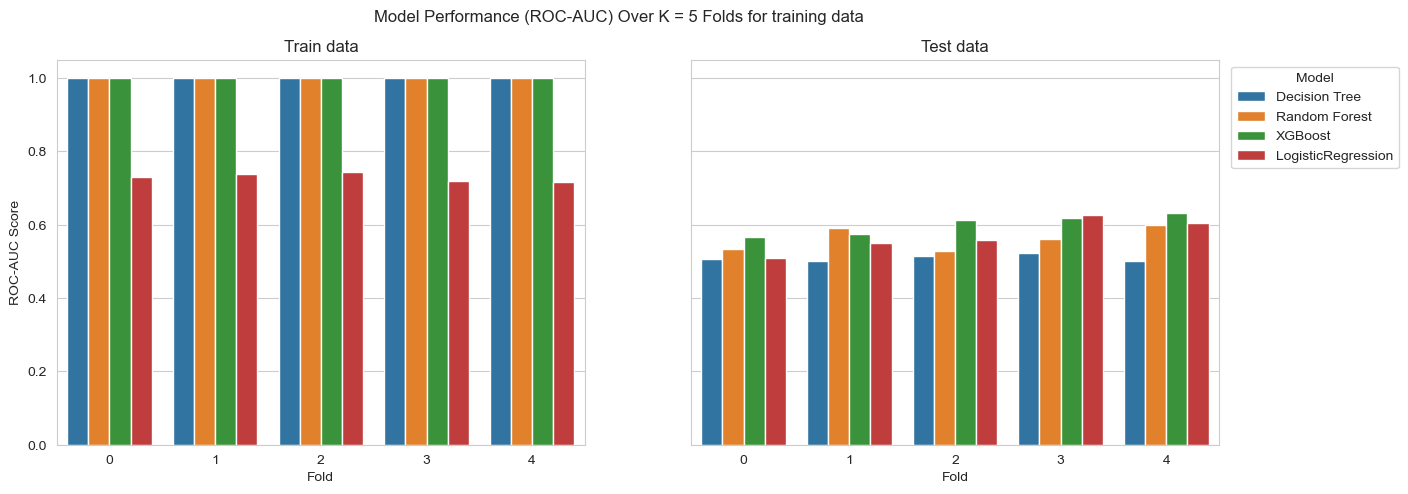

In [31]:
fig, ax = plt.subplots(1,2,figsize = (15,5), sharey=True)

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'train_roc_auc',
                    hue = 'model',
                    ax = ax[0])

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'test_roc_auc',
                    hue = 'model',
                    ax = ax[1])

ax[0].set_ylabel('ROC-AUC Score')

ax[0].get_legend().remove()

ax[0].set_title('Train data')

ax[1].set_title('Test data')

ax[1].legend(title = 'Model',bbox_to_anchor = (1.01,1), loc = 'upper left')

ax[1].set_ylabel('')

for a in ax:

    a.set_xlabel('Fold')

plt.suptitle('Model Performance (ROC-AUC) Over K = 5 Folds for training data')

plt.show()

# Testing Models after SMOTE

Using SMOTEC to account for nominal and binary variables. Trying to mitigate the overfitting

In [33]:
transformer = make_column_transformer(
                                    (StandardScaler(), list(interval_vars) + list(num_cols)),
                                    (OrdinalEncoder(), [58]), # Using LE for imblearn purposes
                                    remainder = 'passthrough'
                                    )

In [34]:
smotenc = imblearn.over_sampling.SMOTENC(categorical_features=nominal_vars_pos,
                                         sampling_strategy=0.1,
                                         random_state = 123)

In [60]:
# Models to be tested
pipe_dt = imblearn.pipeline.Pipeline([('scaler',transformer),
                                    ('smotenc',smotenc),
                                    ('ohe',ohe_transformer),
                                    ('DT',dt)])

pipe_rf = imblearn.pipeline.Pipeline([('scaler',transformer),
                                      ('smotenc',smotenc),
                                    ('ohe',ohe_transformer),
                                    ('RF',rf)])

# Instantiating an XGB to match the closest possible characteristics with balanced class_weights
pipe_xgb = imblearn.pipeline.Pipeline([('scaler',transformer),
                                       ('smotenc',smotenc),
                                        ('ohe',ohe_transformer),
                                        ('XGB',xgb)])

pipe_lr = imblearn.pipeline.Pipeline([('scaler',transformer),
                                      ('smotenc',smotenc),
                                    ('ohe',ohe_transformer),
                                    ('LR',lr)])

In [36]:
models_dict = {'Decision Tree':pipe_dt, 'Random Forest':pipe_rf,'XGBoost':pipe_xgb, 'LogisticRegression':pipe_lr}

In [37]:
results_df = evaluate_models(X_train,y_train, dict_models = models_dict, cv = skfold)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   35.0s remaining:   52.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.2s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   26.2s remaining:   39.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.4s finished


In [38]:
results_plot = results_df.melt(id_vars = ['model','Fold'], value_vars = ['test_roc_auc','train_roc_auc','test_f1','train_f1'])

In [39]:
results_df.groupby('model')[['test_roc_auc','train_roc_auc']].mean()

,test_roc_auc,train_roc_auc
model,,
Decision Tree,0.504083,1.00000
LogisticRegression,0.587116,0.74342
Random Forest,0.568536,1.00000
XGBoost,0.592831,1.00000


All models clearly overfit on training data

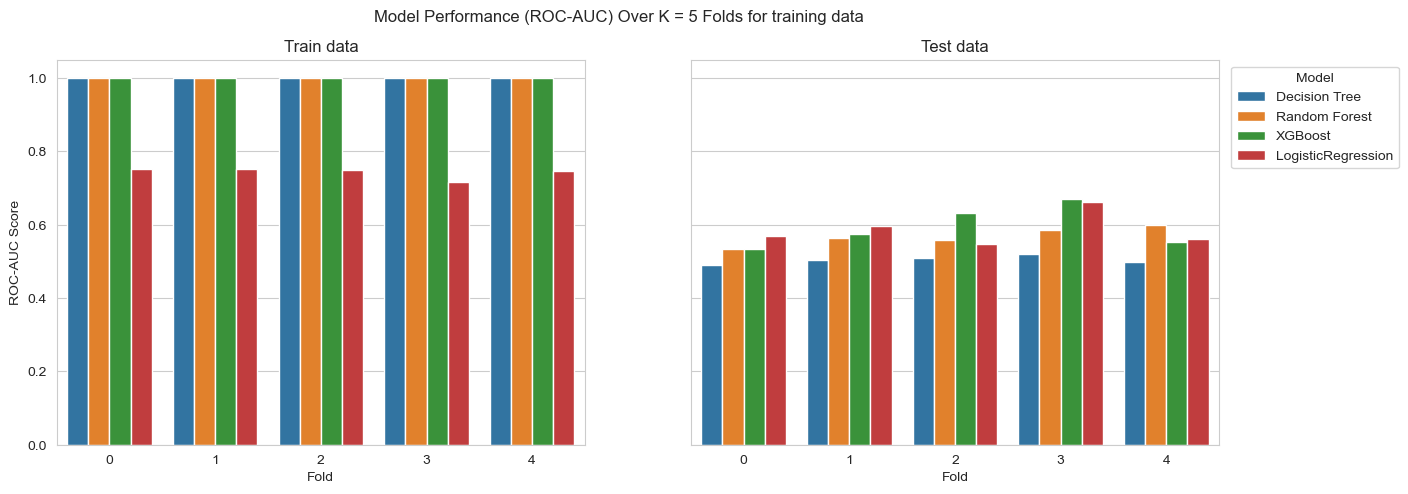

In [40]:
fig, ax = plt.subplots(1,2,figsize = (15,5), sharey=True)

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'train_roc_auc',
                    hue = 'model',
                    ax = ax[0])

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'test_roc_auc',
                    hue = 'model',
                    ax = ax[1])

ax[0].set_ylabel('ROC-AUC Score')

ax[0].get_legend().remove()

ax[0].set_title('Train data')

ax[1].set_title('Test data')

ax[1].legend(title = 'Model',bbox_to_anchor = (1.01,1), loc = 'upper left')

ax[1].set_ylabel('')

for a in ax:

    a.set_xlabel('Fold')

plt.suptitle('Model Performance (ROC-AUC) Over K = 5 Folds for training data')

plt.show()

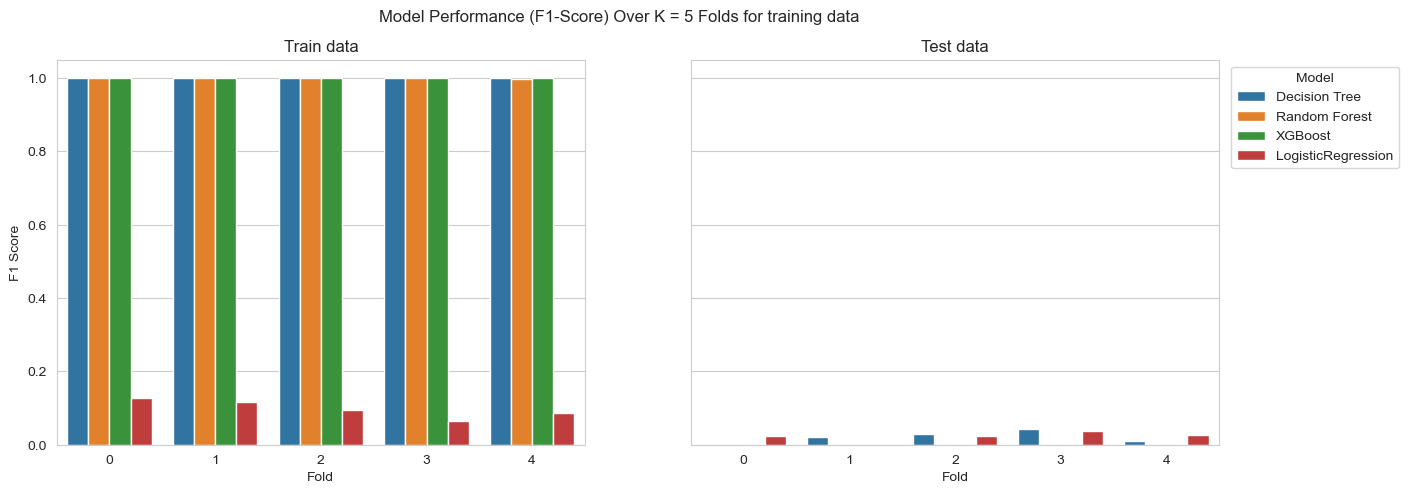

In [41]:
fig, ax = plt.subplots(1,2,figsize = (15,5), sharey=True)

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'train_f1',
                    hue = 'model',
                    ax = ax[0])

sns.barplot(data = results_df,
                    x = 'Fold',
                    y = 'test_f1',
                    hue = 'model',
                    ax = ax[1])

ax[0].set_ylabel('F1 Score')

ax[0].get_legend().remove()

ax[0].set_title('Train data')

ax[1].set_title('Test data')

ax[1].legend(title = 'Model',bbox_to_anchor = (1.01,1), loc = 'upper left')

ax[1].set_ylabel('')

for a in ax:

    a.set_xlabel('Fold')

plt.suptitle('Model Performance (F1-Score) Over K = 5 Folds for training data')

plt.show()

The Vanilla Models overfit. This was expected since there is a really high unbalance between classes and the nature of tree-based learning models. 
Either way, SMOTE enhaces test prediction performance. Let's try tuning the models to see if the results are useful.

# Hyperparameter Tuning

In [44]:
dt_params = {'DT__max_depth':[5,7,10],
             'DT__min_samples_split':[2,5,10],
             'DT__min_samples_leaf':[1,3,5]}

rf_params = {'RF__n_estimators':[100,200,300],
             'RF__max_depth':[2,3]}

xgb_params = {'XGB__n_estimators':[100,200,300],
              'XGB__max_depth':[2,3],
              'XGB__learning_rate':[0.1,0.2,0.3],
              'XGB__scale_pos_weight':[80],
              'XGB__alpha':[0,1,1.5]}

lr_params = {'LR__C':[0.1,0.5,0.75,1]}

In [64]:
model_search_list = list(zip([pipe_dt, pipe_rf, pipe_xgb, pipe_lr],
                                [dt_params, rf_params, xgb_params, lr_params],
                                ['DT','RF','XGB','LR']))

In [75]:
for model, params, name in model_search_list[1:]:

    print(f'Running for {name}')

    cv = GridSearchCV(model,
                        params,
                        scoring = 'roc_auc',
                        n_jobs = -1,
                        cv = skfold,
                        verbose = 1)
    
    cv.fit(X_train, y_train)

    print(cv.cv_results_, end = '\n\n')

    print('Mean test score:', cv.cv_results_['mean_test_score'])

    with open(f'models/{name}_best_estimator.pkl', 'wb') as file:

        pickle.dump(cv.best_estimator_, file)

Running for RF
Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'mean_fit_time': array([33.65394735, 34.14677362, 41.60011029, 39.2324214 , 39.15337157,
       40.22520485]), 'std_fit_time': array([4.60982563, 2.90424342, 3.36072669, 2.23222248, 2.38043896,
       1.95845783]), 'mean_score_time': array([1.32561545, 2.13673596, 2.26830478, 1.29840665, 1.37180781,
       0.77524819]), 'std_score_time': array([0.74348096, 0.8560986 , 0.98865305, 0.88703398, 1.13857778,
       0.28890001]), 'param_RF__max_depth': masked_array(data=[2, 2, 2, 3, 3, 3],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_RF__n_estimators': masked_array(data=[100, 200, 300, 100, 200, 300],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'RF__max_depth': 2, 'RF__n_estimators': 100}, {'RF__max_depth': 2, 'RF__n_estimators': 200}, {'RF__max_depth': 2, 'RF__n_es

# Predictions on test set without SMOTE

In [264]:
model_result_dict = {'model':[],
                     'auc_score':[],
                     'f1_score':[]}

for name, model in models_dict.items():

    model.fit(X_test, y_test)

    y_pred = model.predict(X_test)
    
    score_auc = roc_auc_score(y_test, y_pred)

    score_f1 = f1_score(y_test, y_pred)

    model_result_dict['model'].append(name)

    model_result_dict['auc_score'].append(score_auc)

    model_result_dict['f1_score'].append(score_f1)

model_result_frame = pd.DataFrame().from_dict(model_result_dict)

[22:33:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_thread" } are not used.



In [265]:
model_result_frame

,model,auc_score,f1_score
0,"(ColumnTransformer(remainder='passthrough',\n ...",0.490979,<function f1_score at 0x0000018B3BDBF400>
1,"(ColumnTransformer(remainder='passthrough',\n ...",0.523038,<function f1_score at 0x0000018B3BDBF400>
2,"(ColumnTransformer(remainder='passthrough',\n ...",0.531478,<function f1_score at 0x0000018B3BDBF400>
3,"(ColumnTransformer(remainder='passthrough',\n ...",0.528848,<function f1_score at 0x0000018B3BDBF400>
